<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Accuracy on SOTA datasets 

We showed in the [01_training_and_evaluation_introduction](01_training_and_evaluation_introduction.ipynb) notebook how to train a DNN and use its feature embedding for image retrieval. In that notebook, the DNN was trained using a standard image classification loss.

More accurate similarity measures are typically based on DNNs which are trained explicitly for image similarity using Triplet Learning such as the [FaceNet](https://arxiv.org/pdf/1503.03832.pdf) paper. While these approaches achieve good accuracy, they are conceptually complex, slower, and more difficult to train/converge due to issue such as how to mine relevant triplets.

A recent paper from BMVC 2019 titled "[Classification is a Strong Baseline for Deep Metric Learning](https://arxiv.org/abs/1811.12649)" argues that this extra overhead is not necessary. Indeed, by making small changes to standard classification DNNs, the authors achieve results which are comparable or better than the state-of-the-art on three common datasets (CARS196, CUB200-2011, SOP).

This notebook aims to implements the paper, and reproduces reported results. 


### Datasets

Three of the most popular research datasets were used to evaluate this notebook, namely CARS-196, CUB-200-2011, and SOP.

| Name | #classes  | #images |
| ---- | --------- | ------- |
| CARS-196 | 196   | ~16,000 | 
| CUB-200-2011 |200| ~12,000 |
| SOP  |22634      | ~120,000|


We follow the literature closely to replicate the same train/test splits and the same evaluation protocal as most publications (see eg this [paper](https://arxiv.org/abs/1511.06452)). For the datasets above this means that out of the total N classes, all images within the first N/2 classes are used for training the DNN, and the remaining images are used for evaluating the image retrieval. Note that all images for a class are either fully assigned to training or to testing.


### Results

Using our (partial) implementation of the [BMVC 2019 paper](https://arxiv.org/abs/1811.12649) in this notebook, we achieve significant improvements compared to using the standard image classification loss in the [01_training_and_evaluation_introduction](01_training_and_evaluation_introduction.ipynb) notebook. This can be seen in the table below using the Recall@1 measure. Furthermore, we noticed that model convergence and over-fitting is much less of an issue with this notebook.

We aim to use similar parameters as reported in the paper to allow for a fair comparison. That is, we also use a ResNet-50 architecture, with 224 pixel input resolution, and a 512-dimensional embedding.

Recall@1 accuracies for the datasets:

|               | CARS-196 | CUB-200-2011 | SOP |
| ------------- | -------- | ------------ | --- |
| 01 notebook   |    75%   |     53%      | 57% |
| This notebook |    83%   |     59%      | 70% |
| Reported in paper| 84%   |     61%      | 78% | 

Note the big gain in improvement compared to DNN training using standard classification loss (first row) versus using the suggested NormSoftmax loss (second row). For the CARS-196 and CUB-200-2011 datasets, our Recall@1 numbers are very close to the numbers reported in the [BMVC 2019 paper](https://arxiv.org/abs/1811.12649), however we weren't able to match the reported accuracy on the SOP dataset. The paper also shows further improvements when increasing the embedding dimension from 512 to 2048, however we were not able to replicate this.

## Initialization

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Regular python libraries
import sys, os
import numpy as np
from pathlib import Path
import random

import scrapbook as sb

# fast.ai
import fastai
from fastai.vision import (
    accuracy,
    cnn_learner,
    DatasetType,
    ImageList,
    imagenet_stats,
    models,
    partial,
)

# Computer Vision repository
sys.path.extend([".", "../.."])  # to access the utils_cv library
from utils_cv.classification.data import Urls
from utils_cv.classification.model import TrainMetricsRecorder
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor, db_num_workers
from utils_cv.similarity.data import comparative_set_builder
from utils_cv.similarity.metrics import (
    compute_distances,
    positive_image_ranks,
    recall_at_k,
)
from utils_cv.similarity.model import compute_features, compute_features_learner
from utils_cv.similarity.plot import (
    plot_comparative_set,
    plot_distances,
    plot_ranks_distribution,
    plot_recalls,
)

In [3]:
print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.57
Torch is using GPU: Tesla V100-PCIE-16GB


## Data & Parameters

A small dataset is provided below to illustrate how to run this notebook. For our experiments, we used mainly the three research datasets mentioned above.

In [4]:
# Set dataset, model and evaluation parameters
DATA_FINETUNE_PATH = "/home/pabuehle/Desktop/data/cub_200_2011/train"
DATA_RANKING_PATH = "/home/pabuehle/Desktop/data/cub_200_2011/test"
#DATA_FINETUNE_PATH = "/home/pabuehle/Desktop/data/cars196/train"
#DATA_RANKING_PATH = "/home/pabuehle/Desktop/data/cars196/test"
#DATA_FINETUNE_PATH = "/home/pabuehle/Desktop/data/sop/train"
#DATA_RANKING_PATH = "/home/pabuehle/Desktop/data/sop/test"
#DATA_FINETUNE_PATH = "C:/Users/pabuehle/Desktop/data/cub_200_2011_subset3/train"
#DATA_RANKING_PATH = "C:/Users/pabuehle/Desktop/data/cub_200_2011_subset3/test"
#DATA_FINETUNE_PATH = "C:/Users/pabuehle/Desktop/data/cub_200_2011/train"
#DATA_RANKING_PATH = "C:/Users/pabuehle/Desktop/data/cub_200_2011/test"

#data_root_dir = unzip_url("https://cvbp.blob.core.windows.net/public/datasets/image_similarity/fridgeObjectsImageRetrieval.zip", exist_ok = True)
#DATA_FINETUNE_PATH = os.path.join(data_root_dir, "train")
#DATA_RANKING_PATH  = os.path.join(data_root_dir, "test")

# DNN configuration and learning parameters
EPOCHS_HEAD = 0
EPOCHS_BODY = 6 #20 # 2*24

HEAD_LEARNING_RATE = 0.01                      # 0.01
BODY_LEARNING_RATE = 0.01

BATCH_SIZE = 32
ARCHITECTURE = models.resnet50
IM_SIZE = 224 #300
DROPOUT = 0 

# Proposed in BMVC 2019 paper: "Classification is a Strong Baseline for Deep Metric Learning"
use_norm_softmax_loss = True 
BO_REMOVE_ALL_HEAD = True
EMBEDDING_DIM = 4*512
TEMPERATURE = 0.05

We can now build our training data object. use most images for training, and only a small percentage of the images for validation since we only need a rough estimate of the validation loss.

\FINE-TUNING:
Training set: 5689 images
Validation set: 175 images


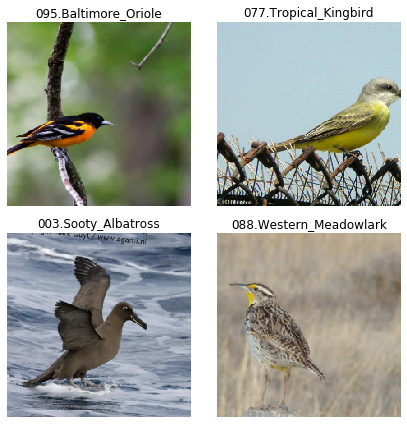

In [5]:
# Load images into fast.ai's ImageDataBunch object
random.seed(642)
data_finetune = (
    ImageList.from_folder(DATA_FINETUNE_PATH)
    .split_by_rand_pct(valid_pct=0.03, seed=20) # Keep a few validation images to estimate validation loss 
    .label_from_folder()
    .transform(tfms=fastai.vision.transform.get_transforms(), size=IM_SIZE)
    .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
    .normalize(imagenet_stats)
)

print(f"""\FINE-TUNING:
Training set: {len(data_finetune.train_ds.x)} images
Validation set: {len(data_finetune.valid_ds.x)} images\
"""
)

data_finetune.show_batch(rows=2, figsize=(6, 6))

## Classification model fine-tuning

We begin by retrieving a [ResNet18](https://arxiv.org/pdf/1512.03385.pdf) CNN from fast.ai's library which is pre-trained on ImageNet, and fine-tune the model on our training set. We use the same training parameters and take the same approach as what we did in our [classification notebooks](https://github.com/microsoft/ComputerVision/tree/master/classification/notebooks), training first the (new) last layer only, and then the full DNN.

Note how we train the DNN here on an image classification task but will use it as featurizer later for image similarity.

In [6]:
learn = cnn_learner(
    data_finetune,
    ARCHITECTURE,
    metrics=[],
    ps=DROPOUT 
)

In [7]:
import math
import torch
import torch.nn as nn
from fastai.layers import FlattenedLoss
from IPython.core.debugger import set_trace

NUMBER_CLASSES = len(data_finetune.classes)
#device = fastai.torch_core.defaults.device
#print(f"Using torch device: {device}")


if BO_REMOVE_ALL_HEAD:
    FEATURE_DIM = 2048 
else:
    FEATURE_DIM = 512 #4096 #512   #learn.model[1][-1].in_features

    
    
class L2NormalizedLinearLayer(nn.Module):
    def __init__(self):
        super(L2NormalizedLinearLayer, self).__init__()
        #tmp = nn.Parameter(torch.Tensor(NUMBER_CLASSES, EMBEDDING_DIM))       
        #self.weight = fastai.layers.ParameterModule(tmp).val
        
        self.weight = nn.Parameter(torch.Tensor(NUMBER_CLASSES, EMBEDDING_DIM))           
        #self.weight = nn.Linear(EMBEDDING_DIM, NUMBER_CLASSES, bias = False).weight  #.cuda(device)
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        #self.fc = nn.Linear(EMBEDDING_DIM, NUMBER_CLASSES, bias = False)
    
    def forward(self, x):
        #prediction_logits = self.fc(x)
        norm_weight = nn.functional.normalize(self.weight, dim=1)
        prediction_logits = nn.functional.linear(x, norm_weight)
        return prediction_logits
        
    
class EmbeddedFeatureWrapper(nn.Module):
    def __init__(self, input_dim=FEATURE_DIM, output_dim=EMBEDDING_DIM):
        super(EmbeddedFeatureWrapper, self).__init__()
        if BO_REMOVE_ALL_HEAD:
            self.pool = nn.AdaptiveAvgPool2d(1)
        self.standardize = nn.LayerNorm(input_dim, elementwise_affine = False)
        self.remap = None
        if input_dim != output_dim:
           sdf
           self.remap = nn.Linear(input_dim, output_dim, bias = False)  #.cuda(device)
        
    def forward(self, x):
        if BO_REMOVE_ALL_HEAD:
            x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.standardize(x)
        if self.remap:
           sdf
           x = self.remap(x)
        x = nn.functional.normalize(x, dim=1)
        return x
    
    
    
    
# Copied and slightly modified from: 
# https://github.com/azgo14/classification_metric_learning
class NormSoftmaxLoss(nn.Module):
    """
    L2 normalize weights and apply temperature scaling on logits.
    """
    def __init__(self, dim=EMBEDDING_DIM, num_instances=NUMBER_CLASSES, temperature=TEMPERATURE):
        super(NormSoftmaxLoss, self).__init__() 
        #self.weight = nn.Parameter(torch.Tensor(num_instances, dim))  #.cuda(device)
        #print("self.weight.requires_grad = " + str(self.weight.requires_grad))
        # Initialization from nn.Linear (https://github.com/pytorch/pytorch/blob/v1.0.0/torch/nn/modules/linear.py#L129)
        #stdv = 1. / math.sqrt(self.weight.size(1))
        #self.weight.data.uniform_(-stdv, stdv)
        self.temperature = temperature
        self.loss_fn = nn.CrossEntropyLoss()
 
    def forward(self, embeddings, instance_targets):
        #norm_weight = nn.functional.normalize(self.weight, dim=1)
        #prediction_logits = nn.functional.linear(embeddings, norm_weight)
        prediction_logits = embeddings
        loss = self.loss_fn(prediction_logits / self.temperature, instance_targets)
        return loss
    
    

In [8]:
# def get_learner(model, data, base_arch, cut=None, pretrained:bool=True,
#                 lin_ftrs=None, ps=0.5, custom_head=None,
#                 split_on=None, bn_final=False, init=nn.init.kaiming_normal_,
#                 concat_pool:bool=True, **kwargs):
#     "Build convnet style learner."
# #     meta = fastai.learner.cnn_config(base_arch)
# #     #model = create_cnn_model(base_arch, data.c, cut, pretrained, lin_ftrs, ps=ps, custom_head=custom_head,
# #     #    bn_final=bn_final, concat_pool=concat_pool)
# #     learn = fastai.basic_train.Learner(data, model, **kwargs)
# #     learn.split(split_on or meta['split'])
# #     if pretrained: learn.freeze()
# #     #if init: apply_init(model[1], init)
# #     return learn
#     return fastai.vision.Learner(data, model)


In [9]:
if use_norm_softmax_loss:
    

    # Update model
    print("** Before model modification **")
    print(learn.model[1])
    
    if not BO_REMOVE_ALL_HEAD:
        #modules = [l for l in learn.model[1][:2]] # remove also batch-norm -- likely worse results than keeping it
        modules = [l for l in learn.model[1][:3]]  # keep batch-norm
        #modules = [l for l in learn.model[1][:-1]] # keep even down-projecting to 512 value
        modules.append(EmbeddedFeatureWrapper())
        modules.append(L2NormalizedLinearLayer())
        learn.model[1] = torch.nn.Sequential(*modules)
    else:
        learn.model[1] = torch.nn.Sequential(EmbeddedFeatureWrapper(), L2NormalizedLinearLayer())

    learn = fastai.vision.Learner(data_finetune, learn.model)
#     get_learner(
#         learn.model,
#         data_finetune,
#         ARCHITECTURE,
#         metrics=[],
#         ps=DROPOUT,
#     )

    
    # Update loss function from section 3.2 in the paper
    learn.loss_func = FlattenedLoss(NormSoftmaxLoss)

    learn.model.cuda()

    print("\n** After model modification **")
    print(learn.model[1])

** Before model modification **
Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=4096, out_features=512, bias=True)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=512, out_features=100, bias=True)
)

** After model modification **
Sequential(
  (0): EmbeddedFeatureWrapper(
    (pool): AdaptiveAvgPool2d(output_size=1)
    (standardize): LayerNorm((2048,), eps=1e-05, elementwise_affine=False)
  )
  (1): L2NormalizedLinearLayer()
)


### Run DNN training

In [10]:
learn.model[1][1].weight[0][:10]

tensor([-0.0098, -0.0148, -0.0043, -0.0114,  0.0127, -0.0206, -0.0169, -0.0017,
         0.0217,  0.0010], device='cuda:0', grad_fn=<SliceBackward>)

In [11]:
# Train the last layer using a larger rate since most of the DNN is fixed.
learn.fit_one_cycle(EPOCHS_HEAD, HEAD_LEARNING_RATE) 

epoch,train_loss,valid_loss,time


/data/anaconda/envs/cv/lib/python3.6/site-packages/fastprogress/fastprogress.py:102: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [12]:
learn.model[1][1].weight[0][:10]

tensor([-0.0098, -0.0148, -0.0043, -0.0114,  0.0127, -0.0206, -0.0169, -0.0017,
         0.0217,  0.0010], device='cuda:0', grad_fn=<SliceBackward>)

Let's now unfreeze all the layers and fine-tuning the model more


In [13]:
learn.unfreeze()


In [ ]:
learn.fit_one_cycle(EPOCHS_BODY, BODY_LEARNING_RATE)

epoch,train_loss,valid_loss,time


In [ ]:
learn.model[1][1].weight[0][:10]

## Feature extraction

We now load the ranking set and extract the DNN features for each image 

In [ ]:
# Load images into fast.ai's ImageDataBunch object
data_rank = (
    ImageList.from_folder(DATA_RANKING_PATH)
    .split_none()
    .label_from_folder()
    .transform(size=IM_SIZE) #, resize_method=fastai.vision.image.ResizeMethod.PAD, padding_mode = "zeros")
    .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
    .normalize(imagenet_stats)
)

print(f"""\FINE-TUNING:
Training set: {len(data_rank.train_ds.x)} images
Validation set: {len(data_rank.valid_ds.x)} images\
"""
)

# Display example images
data_rank.show_batch(rows=3, figsize=(12, 6))

The following line will allow us to extract the penultimate layer (ie 512 floating points vector) after running an image  through the model.

In [ ]:
# Use last layer as image representation
if use_norm_softmax_loss:
    embedding_layer = learn.model[1][-2]
else:
    embedding_layer = learn.model[1][-2] 
print(embedding_layer)

In [ ]:
#Compute DNN features for all validation images
dnn_features = compute_features_learner(data_rank, DatasetType.Train, learn, embedding_layer)

## Image Retrieval Example
The cell below shows how to find and display the most similar images in the validation set for a given query image (which we also select from the validation set). This example is similar to the one shown in the [00_webcam.ipynb](https://github.com/microsoft/ComputerVision/tree/master/similarity/notebooks/00_webcam.ipynb) notebook. 

In [ ]:
# Get the DNN feature for the query image
query_im_path =  str(data_rank.train_ds.items[1])
query_feature = dnn_features[query_im_path]
print(f"Query image path: {query_im_path}")
print(f"Query feature dimension: {len(query_feature)}")
assert len(query_feature) == EMBEDDING_DIM

# Compute the distances between the query and all reference images
distances = compute_distances(query_feature, dnn_features)
plot_distances(distances, num_rows=1, num_cols=7, figsize=(15,5))

## Quantitative evaluation

Our approach for quantitative evaluation is as follows:
- We extract the features of each query image in the query set, and search the K most similar images in the gallery set. 
- If one of the K retrieved images have the same label with the query image, then that increases recall.

In [ ]:
#init
rank1_count = 0
labels = data_rank.train_ds.y
#im_paths = [str(s) for s in list(data_rank.train_ds.items)]
im_paths = data_rank.train_ds.items
assert len(labels) == len(im_paths) == len(dnn_features)

query_indices = range(len(im_paths))[::7] #7, 11, 111, only use every nth image to speed up accuracy computation

# Loop over all images and use as query image once
for query_index in query_indices:
    if query_index % 700 == 0:
        print(query_index, len(im_paths))

    # Get query information
    query_im_path =  str(im_paths[query_index])
    query_feature = dnn_features[query_im_path]
    
    # Compute distance to all images in the gallery set
    # L2-normalizes all embeddings before computing the L2 distance.
    # Note that the ranking is identical to setting `method = "cosine"` in the function below)
    # (See: https://en.wikipedia.org/wiki/Cosine_similarity)
    distances = compute_distances(query_feature, dnn_features) #, method = "cosine")

    # Find the smallest distance
    minDist = float('inf')
    minDistIndex = None
    for index, distance in enumerate(distances):
        if index == query_index: #ignore the query image itself
            continue

        if distance[1] < minDist:
            minDist = distance[1]
            minDistIndex = index

    # Compute rank
    if labels[query_index] == labels[minDistIndex]:
        rank1_count += 1
        
print(rank1_count, len(query_indices))

In [ ]:
print("Recall@1 accuracy = {:2.2f}".format(100.0 * rank1_count / len(query_indices)))

In [ ]:
# Log some outputs using scrapbook which are used during testing to verify correct notebook execution
#sb.glue("median_rank", median_rank)
#sb.glue("random_rank", random_rank)